In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier

In [2]:
# import precprocessed data
train = pd.read_csv("trainPreprocessed.csv")
test = pd.read_csv("testPreprocessed.csv")

In [3]:
print(train.shape,test.shape)

(354324, 300) (236216, 299)


In [4]:
train.columns

Index(['TransactionID', 'TransactionDT', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'C1',
       ...
       'ProductCD_S', 'ProductCD_W', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa', 'M4_M0', 'M4_M1',
       'M4_M2', 'isFraud'],
      dtype='object', length=300)

In [ ]:
##remove transactionID from data as it is a unique feature

In [5]:
k = test['TransactionID']

In [6]:
del train['TransactionID']
del test['TransactionID']

In [7]:
y_train = train['isFraud'].copy().values

In [8]:
del train['isFraud']

In [9]:
X_train = train.copy().values

In [10]:
X_test = test.copy().values

In [ ]:
## train and test split using stratify as data is highly imbalanced

In [14]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.20,stratify=y_train)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(283459, 298) (70865, 298) (283459,) (70865,)


In [ ]:
#performing  randomized search cv to find best parameters among grid for model

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
rf = DecisionTreeClassifier(random_state = 42)

In [14]:
print(rf.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 42, 'splitter': 'best'}


In [27]:
    param_grid = {
    'max_depth':[10,20,30,40,50,60,70,80,90,100,150,350,600,None],
    'class_weight':['balanced'],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,None]
}

In [28]:
CV_best = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,cv=3,scoring='roc_auc',n_jobs=-1,n_iter=100,verbose=2)
CV_best.fit(X_train1,y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.1min finished


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 150, 350,
                                                      600, None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, None]},
                   scoring='roc_auc', verbose=2)

In [29]:
print(CV_best.best_params_)

{'min_samples_leaf': 9, 'max_depth': 10, 'class_weight': 'balanced'}


In [ ]:
# training model on  split dataset using best parameters

In [15]:
model= DecisionTreeClassifier(min_samples_leaf=8,class_weight='balanced',max_depth=10)  
model.fit(X_train1, y_train1)  

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=8)

In [ ]:
#predicting output

In [16]:
predprobs = model.predict_proba(X_test1)
predprobs = predprobs[:,1]

In [ ]:
#saving the predicted output to file

Decision Trees: ROC AUC=0.860


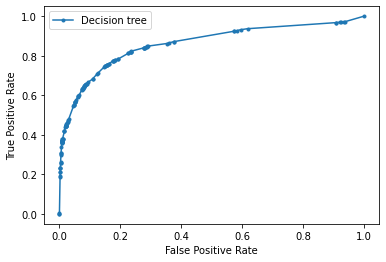

In [18]:
lr_auc = roc_auc_score(y_test1, predprobs)
# summarize scores

print('Decision Trees: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(y_test1, predprobs)
# plot the roc curve for the model

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
## training model on entire dataset

In [ ]:
model= DecisionTreeClassifier(min_samples_leaf=8,class_weight='balanced',max_depth=10)  
model.fit(X_train, y_train)  

In [ ]:
predprobs = model.predict_proba(X_test1)
predprobs = predprobs[:,1]

In [ ]:
submission = pd.DataFrame({'TransactionID':k,'isFraud':predprobs})
submission.head()

In [14]:
filename = 'dtsub.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: dtsub.csv


In [ ]:
## output --- roc curve on test data == 0.8361